In [ ]:
import pykerrp2p as rt

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "axes.prop_cycle": plt.cycler('color', ['k', 'r', 'b', 'g'])})

In [2]:
def rc_range(a):
    return (4 * np.square(np.cos(np.arccos(-a) / 3) + 1e-6), 4 * np.square(np.cos(np.arccos(a) / 3)) - 1e-6)

In [3]:
params = rt.ForwardRayTracingParams()
params.a = 0.8
params.r_s = 10
params.theta_s = 85 * np.pi / 180
params.r_o = 1000
params.nu_r = rt.Sign.NEGATIVE
params.nu_theta = rt.Sign.NEGATIVE
theta_o = 17 * np.pi / 180
phi_o = np.pi / 4

In [4]:
params.rc = 3.2
params.log_abs_d = -2
params.d_sign = rt.Sign.POSITIVE
params.rc_d_to_lambda_q()
res = rt.calc_ray(params)

print("state = ", res.ray_status)
print("theta_f =", res.theta_f)
print("phi_f =", res.phi_f)
print("eta =", res.eta)
print("lambda =", res.lam)

state =  RayStatus.NORMAL
theta_f = 1.0136253214567754
phi_f = -7.669391992178184
eta = 25.825912009147235
lambda = -2.6931451588865922


In [5]:
res2 = rt.find_root(params, 1.0, 4.9, 1e-7)

print("success = ", res2.success)
if res2.success:
  root = res2.root
  print("state = ", root.ray_status)
  print("theta_f =", root.theta_f)
  print("phi_f =", root.phi_f)
  print("eta =", root.eta)
  print("lambda =", root.lam)

success =  True
state =  RayStatus.NORMAL
theta_f = 0.9999999999998748
phi_f = -7.666370614359082
eta = 25.9798867505142
lambda = -2.625865276496997


In [6]:
period = int(np.floor(root.phi_f / (2 * np.pi)))
period

-2

In [7]:
res3 = rt.find_root_period(params, period, 1.1, 4.9, 1e-7)

print("success = ", res3.success)
if res3.success:
  root = res3.root
  print("state = ", root.ray_status)
  print("theta_f =", root.theta_f)
  print("phi_f =", root.phi_f)
  print("eta =", root.eta)
  print("lambda =", root.lam)

success =  True
state =  RayStatus.NORMAL
theta_f = 1.0999999999998376
phi_f = -7.66637061435908
eta = 22.828657098402648
lambda = -3.6008325312984004


# Sweep

In [8]:
rc_l, rc_h = rc_range(0.8)
rc_size = 1000
d_size = 2000
total_size = rc_size * d_size
rc_list = np.linspace(rc_l, rc_h, rc_size)
lgd_list = np.linspace(-10, 2, d_size)
params.d_sign = rt.Sign.POSITIVE
d_list = np.power(10., lgd_list)
rc_x, lgd_y = np.meshgrid(rc_list, lgd_list)

In [9]:
cutoff = 50
tol = 1e-6
data = rt.sweep_rc_d_Float64(params, theta_o, phi_o, rc_list, lgd_list, cutoff, tol)

In [10]:
final_params = np.zeros((len(data.results), 3))
for i in range(len(data.results)):
    final_params[i, 0] = data.results[i].rc
    final_params[i, 1] = data.results[i].log_abs_d
    final_params[i, 2] = data.results[i].lam
final_params

array([[ 2.8287207 , -1.43422441, -0.73150241],
       [ 2.83411121, -4.10390444, -0.76424026],
       [ 2.7937509 , -8.77083278, -0.57018593],
       [ 2.4977115 , -6.13812376,  0.74699247]])

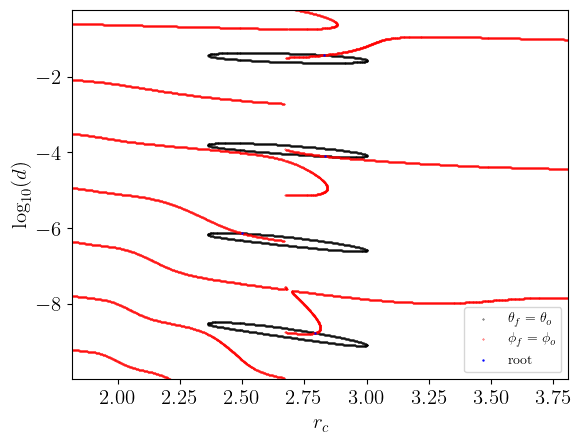

In [11]:
fig, ax = plt.subplots()

ax.scatter(data.theta_roots[:, 0], data.theta_roots[:, 1], s = 0.1, label = r"$\theta_f = \theta_o$")
ax.scatter(data.phi_roots[:, 0], data.phi_roots[:, 1], s = 0.1, label = r"$\phi_f = \phi_o$")
#ax.scatter(theta_roots_closest[:cutoff, 0], theta_roots_closest[:cutoff, 1], s = 0.1, label = r"closest")
ax.scatter(final_params[:, 0], final_params[:, 1], s = 0.5, label = r"$\mathrm{root}$")

ax.set_xlabel(r'$r_c$')
ax.set_ylabel(r'$\log_{10}(d)$')
ax.set_xmargin(0)
ax.set_ymargin(0)

for item in [ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels():
  item.set_fontsize(15)

ax.legend()
fig.savefig("test.png", bbox_inches='tight', dpi=1200)

# Sweep with higher precision (Very Slow)

In [14]:
params = rt.ForwardRayTracingParams()
params.a = 0.8
params.r_s = 10
params.theta_s = 85 * np.pi / 180
params.r_o = 1000
params.nu_r = rt.Sign.NEGATIVE
params.nu_theta = rt.Sign.NEGATIVE
theta_o = 17 * np.pi / 180
phi_o = np.pi / 4

In [15]:
rc_l, rc_h = rc_range(0.8)
rc_size = 100
d_size = 100
total_size = rc_size * d_size
rc_list = np.linspace(rc_l, rc_h, rc_size)
lgd_list = np.linspace(-5, 2, d_size)
params.d_sign = rt.Sign.POSITIVE
d_list = np.power(10., lgd_list)
rc_x, lgd_y = np.meshgrid(rc_list, lgd_list)

In [16]:
cutoff = 30
tol = 1e-10
data = rt.sweep_rc_d_high_Float64(params, theta_o, phi_o, rc_list, lgd_list, cutoff, tol)

In [ ]:
final_params = np.zeros((len(data.results), 3))
for i in range(len(data.results)):
    final_params[i, 0] = data.results[i].rc
    final_params[i, 1] = data.results[i].log_abs_d
    final_params[i, 2] = data.results[i].lam
final_params